# **QUESTION FORMULATION**

---

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_recall_curve, auc

## **Load Processed Data**

In [2]:
train_path = "../data/processed/train.csv"
test_path = "../data/processed/test.csv"
train_df_weather = pd.read_csv(train_path)
test_df_weather = pd.read_csv(test_path)

## **Question 1**

### **1. The question**

*"Trong bối cảnh dữ liệu mất cân bằng (tỷ lệ ngày mưa thấp hơn nhiều so với ngày không mưa), mô hình học máy nào thuộc ba nhóm kiến trúc chính: **Linear** (Logistic Regression), **Bagging** (Random Forest) hay **Boosting** (XGBoost) mang lại hiệu quả cao nhất trong việc tối đa hóa **Recall** (Độ nhạy) để giảm thiểu rủi ro bỏ sót dự báo mưa, trong khi vẫn duy trì chỉ số **F1-Score** ở mức chấp nhận được?"*

### **2. Motivation & Benefits**

#### **2.1. Why is this question worth investigating?**

**A. Bất đối xứng về chi phí sai lầm (Asymmetry of Error Costs):** Khi dự báo khí tượng có hai loại sai số chính có thể đối mặt
* **Sai lầm loại I (False Positive):** Dự báo ngày mai có mưa nhưng thực tế trời nắng. Hệ quả là lãng phí công sức chuẩn bị hoặc chi phí vận hành (ví dụ: nông dân che chắn hoa màu vô ích).
* **Sai lầm loại II (False Negative):** Dự báo ngày mai không mưa nhưng thực tế lại mưa to. Hệ quả là thảm khốc hơn: hoa màu bị hỏng, hệ thống thoát nước thành phố không kịp vận hành gây ngập lụt, hoặc các kế hoạch xây dựng bị đình trệ đột ngột. Và câu hỏi này được đặt ra với động lực tập trung giảm thiểu sai lầm loại II bằng cách đẩy cao chỉ số **Recall**, biến mô hình thành một hệ thống dự báo có tính an toàn cao hơn trước các biến cố thời tiết.

**B. Thách thức từ dữ liệu mất cân bằng:** Tập dữ liệu này có tỷ lệ ngày mưa chỉ chiếm khoảng 22%. Nếu một mô hình đơn giản luôn dự báo là "Không mưa", nó vẫn đạt được độ chính xác (Accuracy) lên tới 78%. Tuy nhiên, mô hình đó hoàn toàn vô dụng cho việc cảnh báo thiên tai. Vì vậy nên việc thử xây dựng nhiều mô hình có các kiến trúc khác nhau nhằm hướng đến việc giảm thiểu thiên kiến khi phát hiện mưa.

#### **2.2. What benefits or insights would be answering this question provide?**

**A. Lợi ích về kỹ thuật:**
* **Hiểu về thuật toán:** Việc trả lời câu hỏi này nhằm tìm hiểu xem kiến trúc học máy nào phản ứng tốt nhất với các kỹ thuật xử lý mất cân bằng như `class_weight` (trong Random Forest/Logistic Regression) hay `scale_pos_weight` (trong XGBoost).
* **Xác định điểm cân bằng tối ưu:** Khi chúng ta cố gắng đẩy Recall lên cao, F1-Score sẽ bắt đầu giảm do Precision sụt giảm (nhiều cảnh báo giả). Việc xác định mức F1-Score chấp nhận được cụ thể là bao nhiêu sẽ giúp chuẩn hóa quy trình huấn luyện mô hình sau này.

**B. Lợi ích thực tiễn:**
Kết quả sẽ cung cấp một nhận định cụ thể như sau: Nếu chọn mô hình ưu tiên sự an toàn tuyệt đối hay ưu tiên sự cân bằng thì cần chọn mô hình nào với ngưỡng bao nhiêu.

#### **2.3. Who would care about the answer?**

* Trong ngành nông nghiệp, nông dân và các doanh nghiệp nông sản cần các dự báo có **Recall** cao để quyết định lịch trình thu hoạch hoặc tưới tiêu. Đối với họ, việc chuẩn bị thừa hơn mức cần thiết hơn là phải bị động trước thiên tai.
* Về phía quản lý đô thị và cứu hộ, các đơn vị vận hành thoát nước và cứu nạn cần các mô hình nhạy nhất có thể để kích hoạt các kịch bản ứng phó khẩn cấp.
* Các nhà phát triển hệ thống DSS (Decision Support Systems) cũng cần một bằng chứng thực nghiệm để lựa chọn thuật toán cốt lõi cho ứng dụng dự báo thời tiết của họ.

#### **2.4. What real-world problem or decision does this inform?**

Nghiên cứu này trực tiếp trả lời cho bài toán: "Làm thế nào để xây dựng một hệ thống dự báo thời tiết có trách nhiệm?". Trong thế giới thực, một dự báo có tỉ lệ đúng 90% nhưng bỏ sót 10% các trận bão lớn là một dự báo thất bại. Vì vậy, nhóm hướng đến việc xây dựng mô hình chuyển dịch từ việc chạy theo con số  có ý nghĩa mang lại độ chính xác tổng thể sang việc chạy theo giá trị thực tế của các thông tin dự báo thông qua việc kiểm soát chỉ số **Recall**.

### **3. Data analysis**

#### **A. Preprocessing**
Công việc tiền xử lí đã được trình bày trong `03_processing.ipynb`

#### **B. Analysis**

#### **1. Written Explanation**

Phần này tập trung tiến hành thử nghiệm và phân tích để trả lời câu hỏi về khả năng tối ưu hóa **Recall** khi xây dựng mô hình học máy. Nhóm sẽ so sánh các kiến trúc học máy khác nhau để xem cách chúng xử lý ranh giới quyết định (decision boundaries) khi đối mặt với dữ liệu bị lệch lớp.

Quy trình phân tích được thiết gồm các bước:

* **Thiết lập bài toán:**
    * Xác định loại bài toán: Phân loại nhị phân (Binary Classification).
    * Mục tiêu: Dự báo giá trị của đặc trưng `RainTomorrow` (1: Có mưa, 0: Không mưa).
    * Thách thức: Đặc thù của dữ liệu cho thấy tỷ lệ lớp "Có mưa" chỉ chiếm khoảng 22.4%. Nếu không xử lí hợp lí, mô hình sẽ mặc định dự báo "Không mưa" để đạt độ chính xác cao nhưng lại không có tác dụng khi áp dụng trong thực tế.

* **Chuẩn bị dữ liệu để huấn luyện và kiểm thử:**
Dữ liệu sau khi tiền xử lí đã được chia theo tỷ lệ 80% huấn luyện (Train) và 20% kiểm thử (Test). Vì vậy giai đoạn chuẩn bị này chỉ cần loại bỏ cột `Date` (không phải đặc trưng học) và `RainTomorrow` (nhãn mục tiêu) cho các biến `X_train`, `X_test` và dữ liệu của cột `RainTomorrow` cho các biến `Y_train`, `Y_test`.

* **Lựa chọn mô hình:**
Nhóm sẽ lựa chọn 3 mô hình đại diện cho 3 kiến trúc học máy khác nhau
    * **Logistic Regression (Linear Model)**: Đại diện cho các mối quan hệ tuyến tính đơn giản. Nhóm sử dụng trọng số `class_weight='balanced'` để ép mô hình quan tâm hơn đến lớp thiểu số.
    * **Random Forest (Bagging)**: Đại diện cho việc kết hợp nhiều cây quyết định để giảm nhiễu. Sử dụng trọng số lớp bên trong từng cây quyết định.
    * **XGBoost (Boosting)**: Đại diện cho việc học từ sai lầm của các mô hình trước. Đây là mô hình mạnh nhất về việc tối ưu hóa các mẫu khó.
    * Để đối phó với sự lệch pha giữa ngày nắng và ngày mưa, nhóm áp dụng kỹ thuật gán trọng số lớp (Class Weighting). Với Logistic Regression và Random Forest, tham số `balanced` sẽ tự động tính toán trọng số nghịch đảo với tần suất xuất hiện của lớp. Còn với XGBoost, nhóm sử dụng `scale_pos_weight` theo công thức:
      $$\text{ratio} = \frac{\text{Tổng số mẫu nhãn 0}}{\text{Tổng số mẫu nhãn 1}}$$
      Điều này buộc các mô hình phải trả giá đắt hơn nếu dự báo sai lớp có mưa.

* **Tính toán các chỉ số đánh giá (Evaluation Metrics)**
    * **Recall**: Đo lường xem trong số các ngày thực tế có mưa, mô hình sẽ dự đoán đúng được bao nhiêu ngày. Đây là chỉ số ưu tiên hàng đầu.
    * **F1-Score**: Để đảm bảo mô hình không dự báo mưa vô tội vạ (ngày nào cũng dự đoán ngày mai có mưa) để đổi lấy điểm **Recall** cao, và ngược lại việc mô hình đẩy được chỉ số **Recall** lên cao nhất cũng sẽ không làm **F1-Score** giảm quá sâu. Tóm lại, chỉ số **F1-score** sẽ giúp cân bằng giữa **Recall** và **Precision**.
    * **ROC-AUC**: Đánh giá năng lực phân loại tổng quát của mô hình.

* **Tối ưu hóa các ngưỡng áp suất có ý nghĩa thực tiễn cho từng vùng khí hậu.**

    Nhóm xây dựng biểu đồ và bảng so sánh các ngưỡng tối ưu giữa các vùng. Mục tiêu là chuyển hóa các phát hiện thống kê thành thông tin có thể hành động được. Thay vì cung cấp các hệ số hồi quy trừu tượng, nhóm hướng đến việc đề xuất các ngưỡng áp suất cụ thể, phù hợp với từng vùng, phục vụ trực tiếp cho cảnh báo và ra quyết định.

#### **2. Code Implementation**

Chuẩn bị dữ liệu Train và Test

In [3]:
X_train = train_df_weather.drop(columns=['Date', 'RainTomorrow'])
y_train = train_df_weather['RainTomorrow']

X_test = test_df_weather.drop(columns=['Date', 'RainTomorrow'])
y_test = test_df_weather['RainTomorrow']

Xây dựng 3 mô hình học máy

In [4]:
# Tính toán tỷ lệ trọng số cho lớp thiểu số (RainTomorrow = 1)
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Cấu hình 3 mô hình
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=ratio, eval_metric='logloss', random_state=42)
}

Tiến hành huấn luyện 3 mô hình, thu thập các chỉ số đánh giá hiệu suất

In [5]:
performance_logs = []
preds_proba = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    preds_proba[name] = y_proba
    
    performance_logs.append({
        "Model": name,
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_proba)
    })

#### **C. Results & Interpretation**

#### **1. Answer the question with evidence**

In [6]:
results_df = pd.DataFrame(performance_logs).sort_values(by="Recall", ascending=False)
display(results_df.round(3))

,Model,Recall,F1-Score,AUC-ROC
2,XGBoost,0.780,0.662,0.893
0,Logistic Regression,0.767,0.621,0.864
1,Random Forest,0.483,0.595,0.887


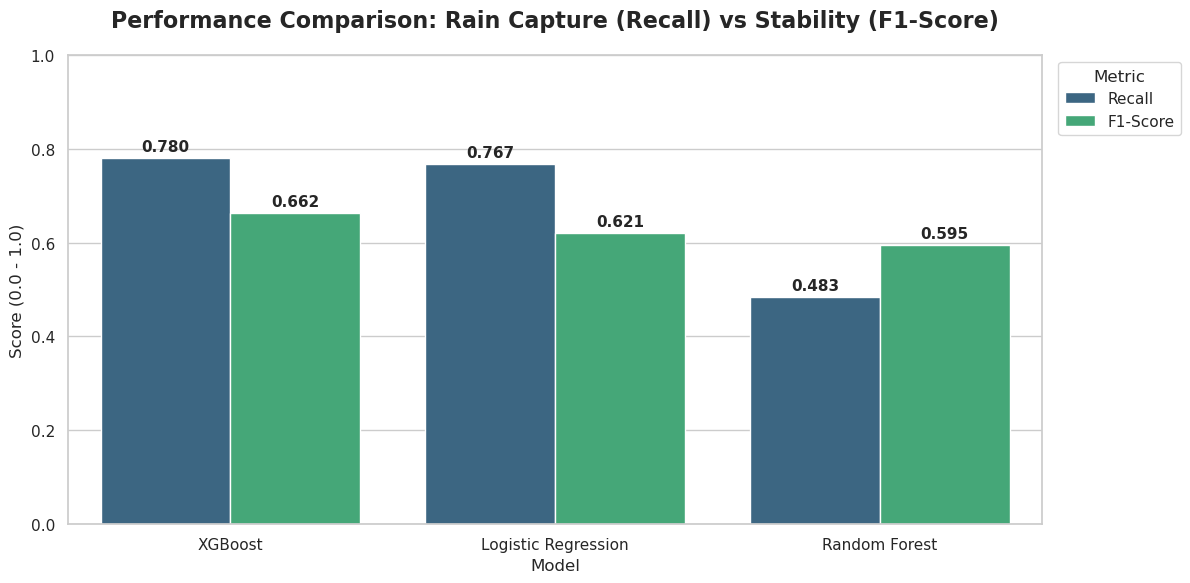

In [7]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

df_plot = results_df.melt(id_vars="Model", value_vars=["Recall", "F1-Score"], 
                          var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_plot, x="Model", y="Score", hue="Metric", palette="viridis")

# Thêm nhãn số liệu trên đầu mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=11, fontweight='bold')

plt.title("Performance Comparison: Rain Capture (Recall) vs Stability (F1-Score)", 
          fontsize=16, pad=20, fontweight='bold')
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title="Metric", loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

Dựa trên bằng chứng thực nghiệm, kiến trúc học máy **Boosting** (**XGBoost**) là mô hình mang lại hiệu quả cao nhất. Nó không chỉ đạt chỉ số **Recall** cao nhất (**0.780**) mà còn duy trì được **F1-Score** tối ưu nhất (**0.662**). Điều này chứng minh rằng phương pháp học tuần tự (Boosting) có khả năng tinh chỉnh ranh giới quyết định tốt hơn để nhận diện lớp thiểu số (ngày mưa) mà không làm mất đi độ chính xác cần thiết. Cụ thể từ các bằng chứng thu được như sau: 
* **Về khả năng tối đa hóa Recall:**
  * **XGBoost** dẫn đầu với **0.780**, theo sát là **Logistic Regression** với **0.767**. Điều này có nghĩa là cả hai đều đoán đúng được gần 80% số ngày mưa thực tế.
  * **Random Forest** có vẻ lép vế hơn với **Recall** chỉ đạt **0.483**, cho thấy kiến trúc Bagging với ngưỡng mặc định 0.5 bị thiên kiến nặng nề về lớp đa số (ngày nắng).
* **Về tính ổn định (F1-Score):**
  * Mặc dù **Logistic Regression** có **Recall** cao, nhưng **F1-Score** chỉ đạt **0.621**.
  * **XGBoost** vượt trội hơn với **F1-Score** là **0.662**. Khoảng cách này chứng minh **XGBoost** ít đưa ra các dự báo mưa bừa bãi hơn mô hình Tuyến tính, giúp tiết kiệm chi phí cho các cảnh báo giả.
* **Năng lực phân loại (AUC-ROC):** Cả 3 mô hình đều đạt **AUC-ROC** rất cao (**> 0.85**), đặc biệt là **XGBoost** đạt **0.893**. Con số này cho thấy mô hình khai thác được tối đa các tín hiệu nhạy cảm từ dữ liệu.

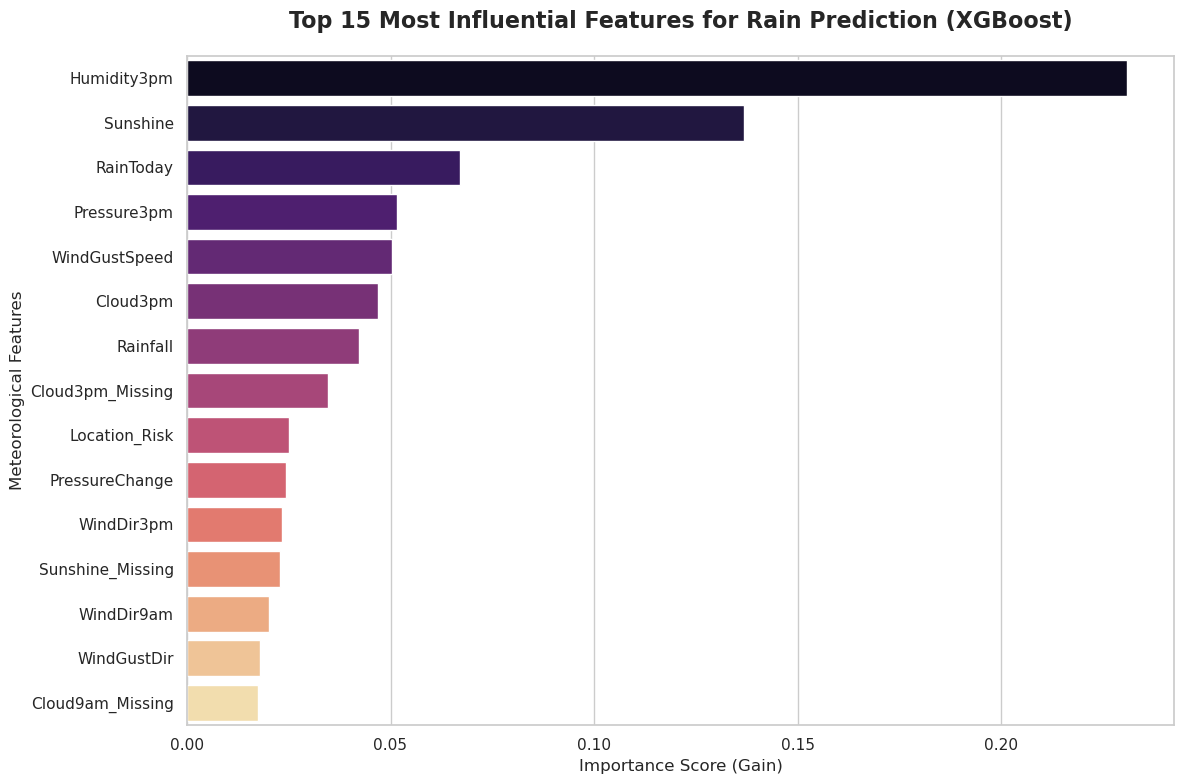

In [8]:
xgb_best = XGBClassifier(scale_pos_weight=ratio, eval_metric='logloss', random_state=42)
xgb_best.fit(X_train, y_train)

feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))

sns.barplot(
    data=feat_importances, 
    x='Importance', 
    y='Feature', 
    palette='magma',
    hue='Feature',
    legend=False
)

plt.title("Top 15 Most Influential Features for Rain Prediction (XGBoost)", 
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Importance Score (Gain)", fontsize=12)
plt.ylabel("Meteorological Features", fontsize=12)

plt.tight_layout()
plt.show()

Bên cạnh đó, từ biểu đồ về độ ảnh hưởng của các đặc trưng cho việc dự đoán có thể thấy:
* Ở nhóm chỉ số về Độ ẩm và Mây (Humidity3pm & Cloud3pm): `Humidity3pm` (Độ ẩm lúc 3 giờ chiều) thường là biến quan trọng nhất. Độ ẩm cao vào buổi chiều cho thấy bầu khí quyển tầng thấp đã tích tụ đủ hơi nước sau một ngày bốc hơi, kết hợp với `Cloud3pm` (Độ che phủ mây) cho thấy đây là điều kiện tiên quyết để hình thành quá trình đối lưu và tạo mưa vào ngày hôm sau. Bằng chứng là từ mô hình, 2 biến này chiếm vị trí top 1 và 6 về độ quan trọng, cho thấy mô hình coi nguồn cung cấp hơi nước trong không khí là tín hiệu dự báo mưa hàng đầu.
* Ở nhóm chỉ số về Năng lượng và Bức xạ: `Sunshine` (Số giờ nắng) có tỷ lệ nghịch với khả năng mưa. Số giờ nắng ít đồng nghĩa với việc mây dày đặc đã ngăn cản bức xạ mặt trời suốt cả ngày. Bằng chứng là từ mô hình, `Sunshine` có trọng số rất cao và việc mô hình bắt được tín hiệu này giúp giảm thiểu đáng kể lỗi False Positive, vì trời nhiều nắng là minh chứng mạnh mẽ cho một khối khí ổn định, khó có khả năng mưa.
* Ở nhóm chỉ số về Động lực học và Áp suất (Pressure3pm & WindGustSpeed): Chỉ số `Pressure3pm` (Áp suất khí quyển) thấp thường đi kèm với các hệ thống áp thấp hoặc rãnh thấp hội tụ. Trong khi đó, `WindGustSpeed` (Tốc độ gió giật) mạnh thường là dấu hiệu của các dấu hiệu thời tiết cực đoan. Bằng chứng là từ mô hình, sự xuất hiện của hai biến này giúp mô hình nhận diện được các hình thái thời tiết động (Dynamic weather patterns) thay vì chỉ nhìn vào độ ẩm tĩnh.
* Tính kế thừa thời tiết: Biến `Rainfall` (Lượng mưa tích luỹ hôm nay) phản ánh tính chất duy trì mưa trong nhiều ngày của thời tiết. Tại nhiều vùng ở Úc, mưa thường kéo dài theo đợt do các hệ thống mây lớn di chuyển chậm. Bằng chứng là từ mô hình, lượng mưa tích luỹ hôm nay đóng vai trò là biến đệm, giúp mô hình duy trì độ chính xác ổn định cho các dự báo ngắn hạn.
* Ngoài ra, qua các kết quả phân tích cho thấy các biến 3pm (buổi chiều) quan trọng hơn các biến 9am (buổi sáng), nó khớp hoàn hảo với thực tế là các cơn mưa thường hình thành sau chu trình nhiệt ngày, khẳng định chất lượng tương đối tốt của mô hình.

Từ các khía cạnh hợp lí trong khí tượng, có thể thấy mô hình có thể được xem là một công cụ dự báo có cơ sở khoa học vững chắc.

#### **2. Practical Meaning & Implications**

* Hỗ trợ nông nghiệp: Với chỉ số Recall ~0.78, hệ thống này có thể giúp nông dân tại Úc chuẩn bị đúng cho 8/10 cơn mưa sắp tới. Đây là mức độ tin cậy đủ cao để áp dụng vào thực tế tưới tiêu và bảo vệ hoa màu.
* Giảm thiểu báo động giả: Chỉ số F1-Score của XGBoost cao nhất đồng nghĩa với việc các cơ quan quản lý thiên tai sẽ tin tưởng nhiều hơn vào các cảnh báo, vì tỷ lệ dự báo có mưa nhưng thực tế nắng được kiểm soát tốt hơn so với mô hình Linear.

#### **3. Surprises & Limitations**

**Key Surprise:** Một bất ngờ lớn là dù có AUC-ROC cao (0.887), chỉ số Recall của Random Forest lại rất thấp (0.483). Điều này chỉ ra rằng dù mô hình có khả năng phân loại tốt, điểm Threshold mặc định là 0.5 lại quá cao đối với một mô hình đang bị áp đảo bởi dữ liệu ngày nắng, vì thể mà mô hình dù nhận diện được các tín hiệu mưa (xác suất 0.3 - 0.4) nhưng không đủ để vượt qua ngưỡng 0.5 này để đưa ra kết luận cuối cùng.

**Limitations:**
* Tính địa phương: Mô hình hiện tại sử dụng chung trọng số cho toàn bộ các trạm đo. Trong tương lai, việc phân tách mô hình theo từng vùng khí hậu (ven biển vs sa mạc) có thể cải thiện F1-Score tốt hơn nữa.
* Thiếu dữ liệu thời gian thực: Dự báo dựa trên các quan sát tĩnh tại 9am/3pm có thể bỏ lỡ các biến động cực ngắn trong ngày dẫn đến các sai số cục bộ.